# Enrich IRCAD data with textures.

### Prepare full size textures using texture synthesis method CUT. Add some randomness to the generated textures to avoid regular checkerboard pattern. Outputs are named according to Cholec classes and are available in `Texture-Synthesis/{tex_folder}` in two versions ('a', 'b') for each tissue.

In [4]:
tex_folder = 'tex_01_49'

In [ ]:
# # Prepare textures using CUT algorithm

# !python ./Texture-Synthesis/texture_synthesis.py -i ./Texture-Synthesis/{tex_folder}/01_b.png -o ./Texture-Synthesis/{tex_folder}/tex01_b.png -n 4 -m Cut
# !python ./Texture-Synthesis/texture_synthesis.py -i ./Texture-Synthesis/{tex_folder}/01_a.png -o ./Texture-Synthesis/{tex_folder}/tex01_a.png -n 4 -m Cut

# !python ./Texture-Synthesis/texture_synthesis.py -i ./Texture-Synthesis/{tex_folder}/02_b.png -o ./Texture-Synthesis/{tex_folder}/tex02_b.png -n 3 -m Cut
# !python ./Texture-Synthesis/texture_synthesis.py -i ./Texture-Synthesis/{tex_folder}/02_a.png -o ./Texture-Synthesis/{tex_folder}/tex02_a.png -n 3 -m Cut

# !python ./Texture-Synthesis/texture_synthesis.py -i ./Texture-Synthesis/{tex_folder}/04_b.png -o ./Texture-Synthesis/{tex_folder}/tex04_b.png -n 4 -m Cut
# !python ./Texture-Synthesis/texture_synthesis.py -i ./Texture-Synthesis/{tex_folder}/04_a.png -o ./Texture-Synthesis/{tex_folder}/tex04_a.png -n 4 -m Cut

# !python ./Texture-Synthesis/texture_synthesis.py -i ./Texture-Synthesis/{tex_folder}/10_b.png -o ./Texture-Synthesis/{tex_folder}/tex10_b.png -n 4 -m Cut
# !python ./Texture-Synthesis/texture_synthesis.py -i ./Texture-Synthesis/{tex_folder}/10_a.png -o ./Texture-Synthesis/{tex_folder}/tex10_a.png -n 4 -m Cut

# !python ./Texture-Synthesis/texture_synthesis.py -i ./Texture-Synthesis/{tex_folder}/12_b.png -o ./Texture-Synthesis/{tex_folder}/tex12_b.png -n 4 -m Cut
# !python ./Texture-Synthesis/texture_synthesis.py -i ./Texture-Synthesis/{tex_folder}/12_a.png -o ./Texture-Synthesis/{tex_folder}/tex12_a.png -n 4 -m Cut

In [ ]:
# # Add some randomness to created textures

# from PIL import Image, ImageFilter
# import random
# from shapely.geometry import Polygon, MultiPoint
# import rasterio.features
# import glob
# import tqdm

# imag_tex_list = glob.glob(f'./Texture-Synthesis/{tex_folder}/tex*_b.png')+glob.glob(f'./Texture-Synthesis/{tex_folder}/tex*_a.png')
# for im in tqdm.tqdm(imag_tex_list):
#     # Load the original image
#     original_image = Image.open(im)  # Replace "original_image.png" with your actual image filename

#     # Define the dimensions of the polygon to be cut
#     polygon_width =int(original_image.width/3)
#     polygon_height = int(original_image.height/3)

#     canvas = original_image.copy()
#     # Generate random vertices for the polygon
#     for i in range(15):
#         vertices = []
#         for _ in range(15):
#             vertices.append((random.randint(0, polygon_width), random.randint(0, polygon_height)))
#         polygon = MultiPoint(vertices).convex_hull
        

#         mask = rasterio.features.rasterize([polygon], out_shape=(polygon_height, polygon_width))
#         mask = Image.fromarray(mask*255).convert("L")

#         # Copy the polygon region from the original image using the mask
#         polygon_region = original_image.copy().crop((0, 0, polygon_width, polygon_height))
#         canvas.paste(polygon_region, ((random.randint(0, original_image.width),(random.randint(0, original_image.height)))), mask=mask)
#         canvas.save(im.replace('.png', '_rand.png'))


## Apply randomized textures on top of sim images. Use segmentation maps for that part. 

In [ ]:
import cv2
import numpy as np
import pickle
import random
import os
import cv2
import numpy as np
import shutil
from tqdm import tqdm
from blendmodes.blend import blendLayers, BlendType
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import torchvision.transforms as transforms



def gamma_correction(img):
    # convert img to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hue, sat, val = cv2.split(hsv)

    # compute gamma = log(mid*255)/log(mean)
    mid = 0.5
    mean = np.mean(val)
    gamma = math.log(mid*255)/math.log(mean)

    # do gamma correction on value channel
    val_gamma = np.power(val, gamma).clip(0,255).astype(np.uint8)

    # combine new value channel with original hue and sat channels
    hsv_gamma = cv2.merge([hue, sat, val_gamma])
    img_gamma = cv2.cvtColor(hsv_gamma, cv2.COLOR_HSV2BGR)

    return img_gamma

In [10]:
tex_folder = 'tex_01_49'
inputs_dir = '/path/to/inputs/'
seg_dir = '/path/to/segmentation_maps' # Segmentation maps need to have CholecSeg classes. They were generated in the 1. preprocessing step
output_dir = '/output/path'

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok = True) 

In [11]:
in_imgs = random.sample(os.listdir(inputs_dir),20000)

for in_img in tqdm(in_imgs):

    img_array = cv2.imread(os.path.join(inputs_dir, in_img))
    img_gamma = gamma_correction(img_array)
    img_gamma = cv2.cvtColor(img_gamma, cv2.COLOR_BGR2RGB)
    seg = cv2.imread(os.path.join(seg_dir, in_img), cv2.IMREAD_GRAYSCALE)


    # Blend the images using the mask
    blended = np.zeros_like(img_array)
    first = True

    for tex in [1,2,4,10,12]:
        rand_dict = {1:'a', 2:'b'}
        mask = (seg == tex).astype(int)
        rand = rand_dict[random.randint(1, 2)]
        tissue = cv2.imread(f'./Texture-Synthesis/{tex_folder}/tex{str(tex).zfill(2)}_{str(rand)}_rand.png')
        tissue = cv2.cvtColor(tissue, cv2.COLOR_BGR2RGB)
        tissue = cv2.resize(tissue, (blended.shape[1], blended.shape[0]), interpolation=cv2.INTER_NEAREST)
        if first:
            for i in range(3):  # Loop over RGB channels
                blended[:,:,i] = tissue[:,:,i] * mask + img_array[:,:,i] * (1-mask)
            first = False
        else:
            for i in range(3):  # Loop over RGB channels
                blended[:,:,i] = tissue[:,:,i] * mask + blended[:,:,i] * (1-mask)

    
    # recolour simulation to match texture
    img_orig_layer = Image.fromarray(img_gamma)
    tex_layer = Image.fromarray(blended)

    blended = blendLayers( tex_layer, img_orig_layer, BlendType.HARDLIGHT)
    blended = blendLayers(blended, tex_layer, BlendType.COLOUR)
    blended = np.array(blended)
    
    
    tool_mask = np.isin(seg,[5,9,13,14,15,16]).astype('uint8')
    for i in range(3):  # Loop over RGB channels
        blended[:,:,i] = img_gamma[:,:,i] * (tool_mask) + blended[:,:,i] * (1-tool_mask)

    blended = cv2.cvtColor(blended, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(output_dir, in_img), blended)


100%|██████████| 10000/10000 [1:06:34<00:00,  2.50it/s]


Text(0.5, 1.0, 'gamma')

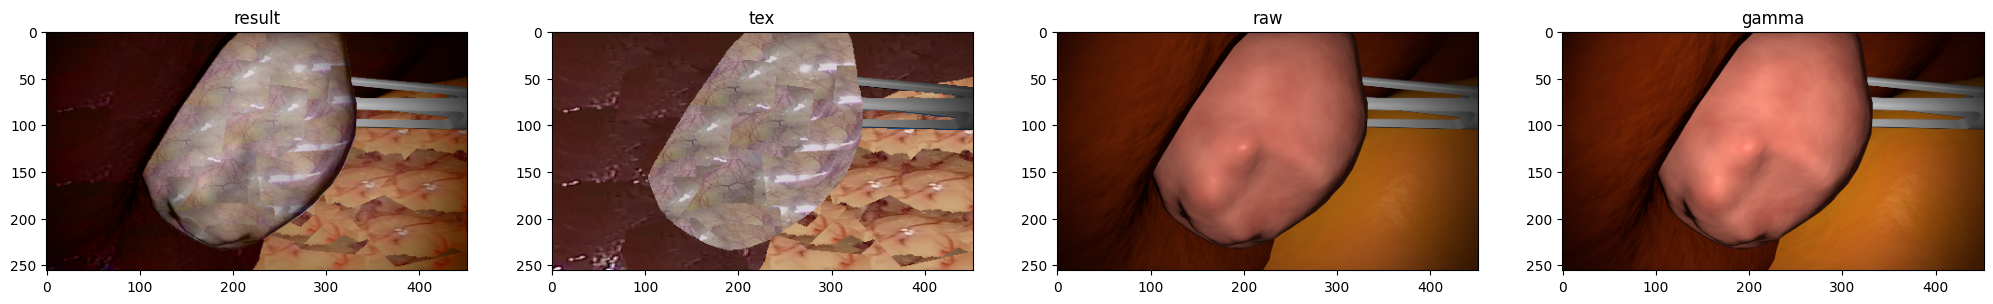

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(25, 10))

# Display the first image in the first subplot
ax1.imshow(blended[:,:,::-1])
ax1.set_title('result')

# Display the first image in the first subplot
ax2.imshow(tex_layer)
ax2.set_title('tex')

# Display the first image in the first subplot
ax3.imshow(img_array[:,:,::-1])
ax3.set_title('raw')

# Display the first image in the first subplot
ax4.imshow(img_orig_layer)
ax4.set_title('gamma')